In [104]:
import csv
import numpy as np
import pandas as pd

In [122]:
x = []
y = []
with open ('/content/data.csv') as file:
  csv_reader = csv.reader(file)
  for row in csv_reader:
    if row[0]=='ID':
      continue
    datum = []
    datum.append(row[3])
    datum.append(row[4])
    if row[1]=='Female':
      datum.append(0)
    else:
      datum.append(1)
    datum.append(float(row[2]))
    bmi = float(row[4])/(float(row[3])**2)
    datum.append(bmi)
    if row[5]=='yes':
      datum.append(0)
    else:
      datum.append(1)
    #if row[6]=='yes':
      #datum.append(0)
    #else:
      #datum.append(1)
    datum.append(float(row[7]))
    datum.append(float(row[8]))
    if row[9]=='no':
      datum.append(0)
    elif row[9]=='Sometimes':
      datum.append(1)
    elif row[9]=='Frequently':
      datum.append(2)
    else:
      datum.append(3)
    if row[10]=='yes':
      datum.append(0)
    else:
      datum.append(1)
    datum.append(float(row[11]))
    #if row[12]=='yes':
      #datum.append(0)
    #else:
      #datum.append(1)
    datum.append(float(row[13]))
    datum.append(float(row[14]))
    if row[15]=='no':
      datum.append(0)
    elif row[15]=='Sometimes':
      datum.append(1)
    elif row[15]=='Frequently':
      datum.append(2)
    else:
      datum.append(3)
    #if row[16]=='Walking':
      #datum.append(0)
    #elif row[16]=='Bike':
      #datum.append(1)
    #elif row[16]=='Public_Transportion':
      #datum.append(2)
    #elif row[16]=='Motorbike':
      #datum.append(3)
    #else:
      #datum.append(4)
    if row[17]=='Insufficient_Weight':
      y.append(0)
    elif row[17]=='Normal_Weight':
      y.append(1)
    elif row[17]=='Overweight_Level_I':
      y.append(2)
    elif row[17]=='Obesity_Type_I':
      y.append(3)
    elif row[17]=='Obesity_Type_II':
      y.append(4)
    else:
      y.append(5)
    x.append(datum)
print(x)
print(y)
x = np.array(x)
y = np.array(y)

[['1.624831', '69.975607', 0, 18.83919, 26.505150938561666, 0, 2.253998, 2.752318, 1, 1, 2.328331, 0.815509, 0.024088, 0], ['1.755643', '137.796884', 0, 21.853826, 44.70611989614442, 0, 3.0, 3.0, 1, 1, 2.184707, 1.978631, 0.838957, 1], ['1.806827', '108.829395', 1, 18.0, 33.33596806335821, 0, 2.0, 1.24884, 1, 1, 2.416213, 1.0, 1.546738, 0], ['1.824901', '120.805715', 1, 24.149036, 36.27512033303055, 0, 2.225149, 3.0, 1, 1, 2.357978, 1.943743, 0.682128, 1], ['1.6', '51', 0, 18.0, 19.921874999999996, 0, 2.0, 3.0, 2, 1, 1.0, 1.0, 1.0, 1], ['1.56', '102', 0, 26.0, 41.913214990138066, 0, 3.0, 3.0, 1, 0, 1.0, 0.0, 1.0, 1], ['1.763343', '133.952675', 0, 19.885655, 43.08020830022258, 0, 3.0, 3.0, 1, 1, 2.835622, 1.419473, 0.816986, 1], ['1.805445', '119.484614', 1, 27.931432, 36.655863883391646, 0, 2.911312, 3.0, 1, 1, 2.501808, 0.94676, 0.785701, 1], ['1.67', '64', 0, 19.0, 22.948115744558788, 1, 3.0, 3.0, 1, 1, 2.0, 2.0, 1.0, 1], ['1.76', '78', 1, 21.0, 25.180785123966942, 0, 3.0, 1.0, 1, 1,

In [69]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [123]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import optuna
from optuna.samplers import TPESampler
import pickle

In [124]:
import warnings
warnings.filterwarnings('ignore')

In [125]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [126]:
base_model = lgb.LGBMClassifier()
base_model.fit(X_train, y_train)

LGBMClassifier()

In [127]:
y_pred = base_model.predict(X_test)

In [128]:
accuracy_score(y_test, y_pred)

0.9905362776025236

In [129]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 3,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

In [130]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=500)

[I 2022-12-23 13:38:51,661] A new study created in memory with name: lightgbm
[I 2022-12-23 13:38:51,778] Trial 0 finished with value: 0.9794952681388013 and parameters: {'lambda_l1': 5.6649755830282306e-05, 'lambda_l2': 0.030403280126677572, 'num_leaves': 2, 'feature_fraction': 0.5813995435791038, 'bagging_fraction': 0.48805353449026784, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 0 with value: 0.9794952681388013.
[I 2022-12-23 13:38:52,048] Trial 1 finished with value: 0.9921135646687698 and parameters: {'lambda_l1': 1.2883876209377052e-05, 'lambda_l2': 3.72312200494449e-05, 'num_leaves': 139, 'feature_fraction': 0.6515167086419769, 'bagging_fraction': 0.8111317002380557, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 1 with value: 0.9921135646687698.
[I 2022-12-23 13:38:52,250] Trial 2 finished with value: 0.9936908517350158 and parameters: {'lambda_l1': 1.763958399884789e-08, 'lambda_l2': 0.010819509974097813, 'num_leaves': 108, 'feature_fraction': 0.7352

In [131]:
print('Best parameters:', study.best_params)

Best parameters: {'lambda_l1': 2.400744032311889e-08, 'lambda_l2': 0.0027410902510900453, 'num_leaves': 154, 'feature_fraction': 0.468378608839672, 'bagging_fraction': 0.9455620243701891, 'bagging_freq': 3, 'min_child_samples': 7}


In [132]:
print('Best value:', study.best_value)

Best value: 1.0


In [133]:
print('Best trial:', study.best_trial)

Best trial: FrozenTrial(number=319, values=[1.0], datetime_start=datetime.datetime(2022, 12, 23, 13, 41, 20, 21935), datetime_complete=datetime.datetime(2022, 12, 23, 13, 41, 20, 794951), params={'lambda_l1': 2.400744032311889e-08, 'lambda_l2': 0.0027410902510900453, 'num_leaves': 154, 'feature_fraction': 0.468378608839672, 'bagging_fraction': 0.9455620243701891, 'bagging_freq': 3, 'min_child_samples': 7}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'min_child_samples': IntDistribution(high=100, log=False, low=5, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, 

In [134]:
model = lgb.LGBMClassifier(**study.best_params)
model.fit(X_train, y_train,  feature_name=['Height', 'Weight', 'Gender', 'Age', 'BMI', 'family_history', 'FCV',
                                     'NMM','CFBM', 'Smoke', 'CW', 'PAF', 'TUT', 'CA'])

LGBMClassifier(bagging_fraction=0.9455620243701891, bagging_freq=3,
               feature_fraction=0.468378608839672,
               lambda_l1=2.400744032311889e-08, lambda_l2=0.0027410902510900453,
               min_child_samples=7, num_leaves=154)

In [135]:
y_pred = model.predict(X_test)

In [136]:
accuracy_score(y_test, y_pred)

1.0

In [137]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        80
           3       1.00      1.00      1.00       112
           4       1.00      1.00      1.00        81
           5       1.00      1.00      1.00       278

    accuracy                           1.00       634
   macro avg       1.00      1.00      1.00       634
weighted avg       1.00      1.00      1.00       634



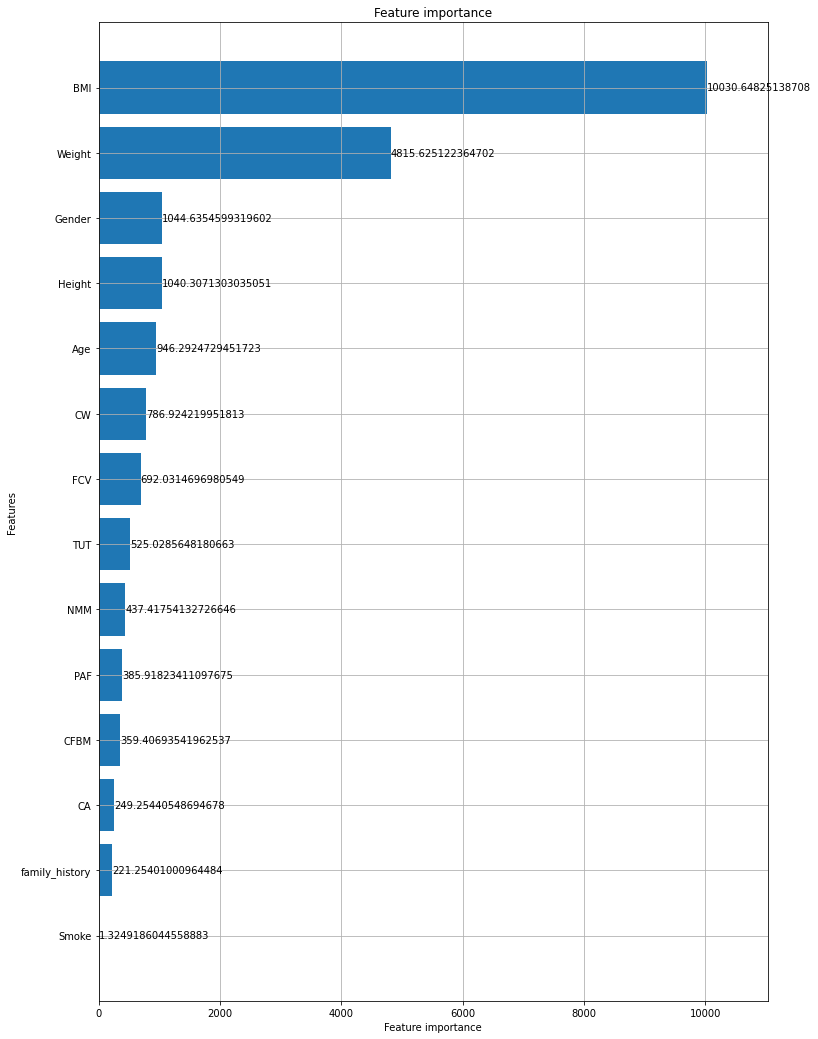

In [138]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,18))
import lightgbm as lgbm
lgbm.plot_importance(model, max_num_features=17, height=0.8, ax=ax, importance_type='gain')
plt.show()